<a href="https://colab.research.google.com/github/basile-bron/Open-Translation/blob/main/OpenTrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pillow pytesseract googletrans==4.0.0-rc1
!sudo apt-get install tesseract-ocr-jpn
!sudo apt-get install tesseract-ocr-kor
!sudo apt-get install tesseract-ocr-jpn-vert
!sudo apt-get install tesseract-lang

!pip install Pillow==9.5.0

!pip install google_trans_new
!pip install -U deep-translator

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=49c5edaa0012f5ab395274fff95b2d7c07e121d2712c799bf29903f70caa2491
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling cha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.1 MB/s eta 0:00:00


In [ ]:
import sys

import cv2
import numpy as np
import pytesseract

from PIL import Image
from googletrans import Translator
translator = Translator()
import re

In [ ]:
translator = Translator()

class Blurb(object):
    def __init__(self, x, y, w, h, text, confidence=100.0):
      """
      Initialize a Blurb object.

      Args:
          x (int): X-coordinate of the top-left corner of the region.
          y (int): Y-coordinate of the top-left corner of the region.
          w (int): Width of the region.
          h (int): Height of the region.
          text (str): The actual text content within the region.
          confidence (float, optional): Confidence level of the OCR system in recognizing the text content.
                                        Defaults to 100.0.
      """
      self.x = x
      self.y = y
      self.w = w
      self.h = h
      self.text = text
      self.confidence = confidence

    def clean_text(self):
      """
      Clean the text content by removing newline characters.

      Returns:
          str: The cleaned text.
      """
      text = self.text
      text = re.sub(r"\n", "", text)
      """
      for letter in text:

          if ord(letter) > 255:
              #print("deleting atrocity")
              text = text.replace(letter, "")
      """

      return text

    def __str__(self):
      """
      Return a string representation of the Blurb object.

      Returns:
          str: The string representation in the format: "x,y w x h confidence%: text".
      """
      return str(self.x) + ',' + str(self.y) + ' ' + str(self.w) + 'x' + str(self.h) + ' ' + str(self.confidence) + '% :' + self.text


class TranslatedBlurb(Blurb):
    def __init__(self, x, y, w, h, text, confidence, translation):
      """
      Initialize a TranslatedBlurb object.

      Args:
          x (int): X-coordinate of the top-left corner of the region.
          y (int): Y-coordinate of the top-left corner of the region.
          w (int): Width of the region.
          h (int): Height of the region.
          text (str): The actual text content within the region.
          confidence (float): Confidence level of the OCR system in recognizing the text content.
          translation (str): The translated text.
      """
      Blurb.__init__(self, x, y, w, h, text, confidence)
      self.translation = translation

    @classmethod
    def as_translated(cls, parent, translation):
      """
      Create a new TranslatedBlurb object based on an existing Blurb object and a translation.

      Args:
          parent (Blurb): The parent Blurb object to inherit attributes from.
          translation (str): The translated text.

      Returns:
          TranslatedBlurb: The new TranslatedBlurb object.
      """
      return cls(parent.x, parent.y, parent.w, parent.h, parent.text, parent.confidence, translation)


def translate_text(text):
    """
    Translate the given text to English.

    Args:
        text (str): The text to be translated.

    Returns:
        str: The translated text in UTF-8 encoded format.
    """
    #if isinstance(text,str):
    translated_text = translator.translate(text, dest='fr')

    return translated_text.text.encode('utf-8')


def translate_blurb(blurb):
    """
    Translate the text content of a Blurb object to English and create a TranslatedBlurb object.

      Args:
          blurb (Blurb): The Blurb object to be translated.

      Returns:
        blurb (Blurb): The Blurb object translated.
    """

    translation = translate_text(blurb.clean_text())
    return TranslatedBlurb.as_translated(blurb, translation)


In [ ]:
"""
    Page segmentation modes:
      0    Orientation and script detection (OSD) only.
      1    Automatic page segmentation with OSD.
      2    Automatic page segmentation, but no OSD, or OCR.
      3    Fully automatic page segmentation, but no OSD. (Default)
      4    Assume a single column of text of variable sizes.
      5    Assume a single uniform block of vertically aligned text.
      6    Assume a single uniform block of text.
      7    Treat the image as a single text line.
      8    Treat the image as a single word.
      9    Treat the image as a single word in a circle.
    10    Treat the image as a single character.
    11    Sparse text. Find as much text as possible in no particular order.
    12    Sparse text with OSD.
    13    Raw line. Treat the image as a single text line,
"""

'\n    Page segmentation modes:\n      0    Orientation and script detection (OSD) only.\n      1    Automatic page segmentation with OSD.\n      2    Automatic page segmentation, but no OSD, or OCR.\n      3    Fully automatic page segmentation, but no OSD. (Default)\n      4    Assume a single column of text of variable sizes.\n      5    Assume a single uniform block of vertically aligned text.\n      6    Assume a single uniform block of text.\n      7    Treat the image as a single text line.\n      8    Treat the image as a single word.\n      9    Treat the image as a single word in a circle.\n    10    Treat the image as a single character.\n    11    Sparse text. Find as much text as possible in no particular order.\n    12    Sparse text with OSD.\n    13    Raw line. Treat the image as a single text line,\n'

In [ ]:
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

def flow_into_box(text, w, font, min_word_on_line=0.3):
    """
    Formats the given text to fit within a specified width.

    Args:
        text (str): The text to format.
        w (int): The width to fit the text into.
        font (PIL.ImageFont.FreeTypeFont, optional): The font to use for measuring text width. Defaults to None.
        min_word_on_line (float, optional): The minimum proportion of a word to be placed on a line. Defaults to 0.3.

    Returns:
        str: The formatted text with line breaks to fit within the specified width.
    """
    if isinstance(text, bytes):
      text = text.decode("utf-8")

    words = text.split()
    lines = []
    current_line = []

    for word in words:
        if current_line:
            """
            # Check if adding the next word exceeds the width limit
            current_line_length = ImageDraw.textbbox((0, 0), " ".join(current_line + [word]), font=font)[2]

            #current_line_length = font.getsize(" ".join(current_line + [word]))[0]
            if current_line_length < w * (1 - min_word_on_line):
                # Add the word to the current line
                current_line.append(word)
            else:
              """
            # Start a new line
            lines.append(" ".join(current_line))
            current_line = [word]
        else:
            # First word on the line
            current_line.append(word)

    if current_line:
        lines.append(" ".join(current_line))

    #print(lines)
    return "\n".join(lines)

In [ ]:
def typeset_blurb(img, blurb):
    if isinstance(blurb, TranslatedBlurb):
        text = blurb.translation
    else:
      if isinstance(text, bytes):
        text = text.decode("utf-8")

    if len(text) > 4:
      area = blurb.w * blurb.h
      fontsize = int(math.sqrt(area) / 10)
      #usingFont = ImageFont.load_default()

      usingFont = ImageFont.truetype("Arial.ttf", fontsize)

      flowed = flow_into_box(text, blurb.w, usingFont)
      if flowed:
        d = ImageDraw.Draw(img)

        # size of the white box behind the translated text
        filling = (255, 255, 255, 170)
        ImageDraw.Draw(img, "RGBA").rounded_rectangle([(blurb.x, blurb.y), (blurb.x+blurb.w, blurb.y+blurb.h)], radius=25,
                                                     fill=filling, width=0)
        #img.paste((255, 255, 255, 128), (blurb.x, blurb.y, blurb.h, blurb.w))

        #pasting the new text on the white out area
        d.text((blurb.x, blurb.y), flowed.strip(), fill=(0, 0, 0))

In [ ]:
import sys
import cv2
import numpy as np
import pytesseract

from PIL import Image

translator = Translator()

def get_params():
    params = ""
    params += "--psm 12"

    configParams = []
    def configParam(param, val):
      return "-c " + param + "=" + val
    configParams.append(("chop_enable", "T"))
    configParams.append(('use_new_state_cost','F'))
    configParams.append(('segment_segcost_rating','F'))
    configParams.append(('enable_new_segsearch','0'))
    configParams.append(('textord_force_make_prop_words','F'))
    configParams.append(('tessedit_char_blacklist', 'ㆍ@-ㅡ《0123456789}><~^/#'))
    configParams.append(('textord_debug_tabfind','0'))
    #configParams.append(('preserve_interword_spaces','1'))

    params += " ".join([configParam(p[0], p[1]) for p in configParams])
    return params

def get_blurbs(img):

  # Convert the input image to grayscale
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Apply adaptive thresholding to create a binary image (black and white) using a Gaussian method.
  # The thresholded image is then inverted using bitwise_not.
  img_gray = cv2.bitwise_not(cv2.adaptiveThreshold(img_gray, 255, cv2.THRESH_BINARY, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 75, 10))

  # Create a 2x2 kernel to be used for erosion operation
  kernel = np.ones((2,2), np.uint8)

  # Erode the image to remove noise and small details by applying the kernel repeatedly.
  # This operation helps to make the text or blurb regions more distinguishable.
  img_gray = cv2.erode(img_gray, kernel, iterations=2)

  # Invert the image again to revert it back to the original orientation.
  img_gray = cv2.bitwise_not(img_gray)

  # Find contours in the processed image using RETR_TREE mode (hierarchical contour retrieval mode)
  # and CHAIN_APPROX_SIMPLE method (compresses horizontal, vertical, and diagonal segments and leaves only their end points).
  contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Create an empty mask image with the same dimensions as the input image.
  mask = np.zeros_like(img)

  # Convert the mask to grayscale (single-channel) for further processing.
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

  # Get the height, width, and number of channels of the input image.
  height, width, channel = img.shape

  pruned_contours = []

  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 100 and area < ((height / 3) * (width / 3)):
      pruned_contours.append(cnt)

  # find contours for the mask for a second pass after pruning the large and small contours
  cv2.drawContours(mask, pruned_contours, -1, (255,255,255), 1)
  contours2, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

  final_mask = cv2.cvtColor(np.zeros_like(img), cv2.COLOR_BGR2GRAY)

  blurbs = []
  for cnt in contours2:
    area = cv2.contourArea(cnt)
    if area > 1000 and area < ((height / 3) * (width / 3)):
      draw_mask = cv2.cvtColor(np.zeros_like(img), cv2.COLOR_BGR2GRAY)
      approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
      #pickle.dump(approx, open("approx.pkl", mode="w"))
      cv2.fillPoly(draw_mask, [approx], (255,0,0))
      cv2.fillPoly(final_mask, [approx], (255,0,0))
      image = cv2.bitwise_and(draw_mask, cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
      draw_mask_inverted = cv2.bitwise_not(draw_mask)
      image = cv2.bitwise_or(image, draw_mask_inverted)
      y = approx[:, 0, 1].min()
      h = approx[:, 0, 1].max() - y
      x = approx[:, 0, 0].min()
      w = approx[:, 0, 0].max() - x
      image = image[y:y+h, x:x+w]

      padding = 10  # Number of pixels for padding

      # Add padding to the image
      image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant', constant_values=255)


      pil_image = Image.fromarray(image)
      display(pil_image)

      #OCR recognition
      text = pytesseract.image_to_string(pil_image, lang="kor", config=get_params())
      text = text.replace("\n", "")
      text = text.replace("\x0c", "")
      display(text)
      #Non UTF8 cleaner

      if text and text.strip():
        for letter in text:
          if ord(letter) > 255:
              #print("deleting atrocity")
              text = text.replace(letter, "")
      if text and text.strip() and text != None:
        #filter out noise under x characters
        if len(text)>3:
          blurb = Blurb(x, y, w, h, text)
          #print(blurb)
          blurbs.append(blurb)
          #print ("Attempt: " + text + ' -> ' + str(translator.translate(text,dest='fr').text))

  return blurbs

.config
001.jpg
translated
.ipynb_checkpoints
Arial.ttf
sample_data


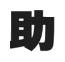

''

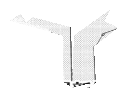

''

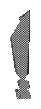

''

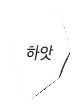

'윈앗”'

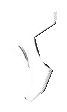

'고'

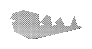

''

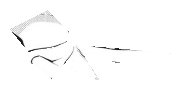

'=ㅅ'

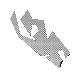

''

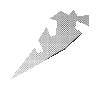

''

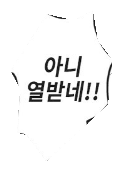

'|아니” 열받내!)ㅣ'

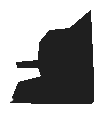

''

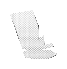

''

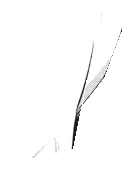

'「'

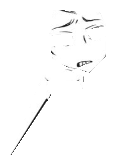

'늦'

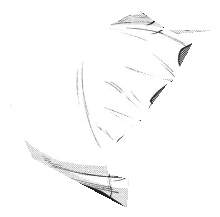

'는'

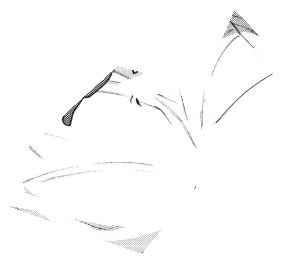

''

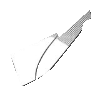

''

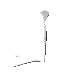

''

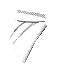

'제)'

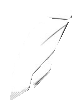

' 제!'

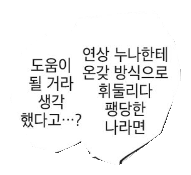

'연상 누나한테도롱이 운갖 방식으로될 거라휘둘리다생각팽당한했다고… :라면 .'

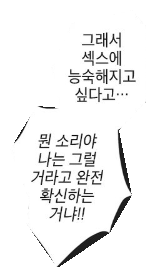

'ㅎㄷ우글…틈띠페위배ㄷ'

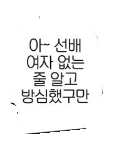

'아 선배여자없!줄알고. 반으'

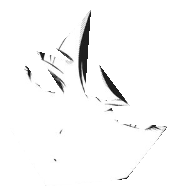

'세'

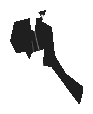

''

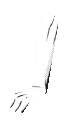

'%'

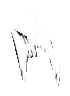

'립'

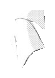

''

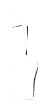

''

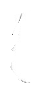

''

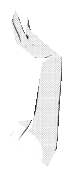

''

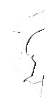

'노'

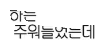

'주워늘냈는데'

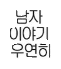

'이우연히'

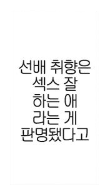

'선배 취향은섹스 잘해애는게판명됐판명됐!다고'

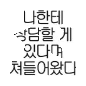

'가나한테담할게있대어왔다'

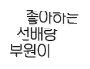

'졸아하는선배랑부원이'

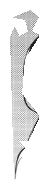

''

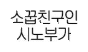

'소꼽친구인시노부가'

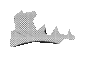

''

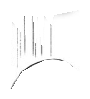

'!'

''

''

/content/translated/0.jpg
Number of translated blurb:3
Number of translated pages:1


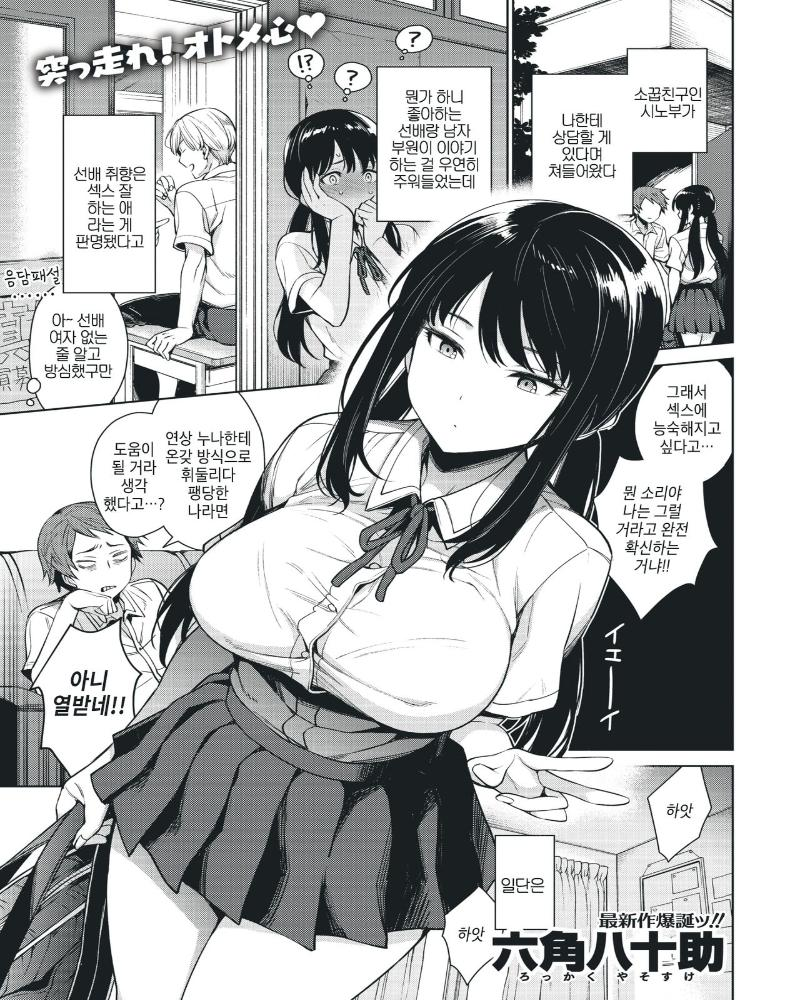

In [ ]:
import os
import cv2
from PIL import Image


def load_images_from_folder(folder):
    images = []
    resize_optimisation = True
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:

            if resize_optimisation:
              # Resize the image to a smaller resolution
              # You can adjust the target width and height as needed
              img = cv2.resize(img,(800,1000))

            images.append(img)


    return images

def load_names_from_folder(folder):
    names = []

    for filename in os.listdir(folder):
        if filename is not None:
            names.append(filename)
            print(filename)

    return names

imgPath = '/content'
transPath = '/content/translated'
images  = load_images_from_folder(imgPath)
names = load_names_from_folder(imgPath)
transImg = []
i = 0
b = 0

for img in images:
  blurbs = get_blurbs(img)
  needTransImg = Image.fromarray(img.copy())

  for blurb in blurbs:
    b = b + 1
    try:
      translated = translate_blurb(blurb)
      typeset_blurb(needTransImg, translated)
    except Exception as e:
      print(e)
      pass
  transImg.append(needTransImg)

for trans in transImg:
        save_file = os.path.join(transPath,str(i) + '.jpg')
        print(save_file)
        trans.save(save_file, format='JPEG')
        i = i + 1

print('Number of translated blurb:' + str(b))
print('Number of translated pages:' + str(i))

#debug colab result
from IPython.display import Image
#Image('018.jpg', width=400, height=600)
Image('translated/0.jpg', width=600, height=800)